In [3]:
import importlib
import utils
import visualization

importlib.reload(utils)
importlib.reload(visualization)
%reload_ext autoreload
%autoreload 2
from utils import *
from visualization import visualize
pd.set_option('display.max_colwidth', None)


In [4]:
# incorrect cases with different sku for same products
excel_path = "/home/viktoria/Downloads/ARBOLES ALIMENTOS EJERCICIO KABELLI.xlsx"

grouped_confident, grouped_review = process_excel_for_duplicates_and_split_by_company(
    excel_path,
    confidence_threshold=93,
    low_confidence_threshold=88
)

for company, df in grouped_confident.items():
    print(f"--- Confident matches for {company} ---")
    print(df.shape[0])

for company, df in grouped_review.items():
    print(f"--- Needs review matches for {company} ---")
    print(df.shape[0])


--- Confident matches for Surtiventas Arbol_24_25 ---
39
--- Confident matches for PRISA Arbol_24_25 ---
22
--- Confident matches for Prinorte Arbol_24_25 ---
8
--- Confident matches for Prisur Arbol_24_25 ---
47
--- Needs review matches for Surtiventas Arbol_24_25 ---
22
--- Needs review matches for PRISA Arbol_24_25 ---
16
--- Needs review matches for Prinorte Arbol_24_25 ---
8
--- Needs review matches for Prisur Arbol_24_25 ---
24


In [5]:
# Correct cases with same and different names
data = load_all_sheets(excel_path)

correct_products = find_similar_products(data, 90, different_sku=False)
correct_products = correct_products.copy()
correct_products = remove_flavor_variants(correct_products)
columns_to_show = [col for col in correct_products.columns if col not in ['Numbers 1', 'Numbers 2']]
correct_products = correct_products.loc[:, columns_to_show]
exact_matches = correct_products[correct_products['Similarity'] == 100]
partial_matches = correct_products[correct_products['Similarity'] < 100]
grouped_exact, grouped_partial = split_matches_by_company(exact_matches, partial_matches)

# Print or explore
for company, df in grouped_exact.items():
    print(f"\n--- Exact matches for {company} ---")
    print(df.shape[0])

for company, df in grouped_partial.items():
    print(f"\n--- Partial matches for {company} ---")
    print(df.shape[0])



--- Exact matches for Prinorte Arbol_24_25 ---
91

--- Exact matches for PRISA Arbol_24_25 ---
46

--- Exact matches for Surtiventas Arbol_24_25 ---
182

--- Exact matches for Prisur Arbol_24_25 ---
209

--- Partial matches for Prinorte Arbol_24_25 ---
47

--- Partial matches for PRISA Arbol_24_25 ---
65

--- Partial matches for Surtiventas Arbol_24_25 ---
147

--- Partial matches for Prisur Arbol_24_25 ---
131


In [6]:
91+46+182+209
# cada error involucra 2 subempresas  por eso 582 = 264 * 2 del reporte integral

528

In [7]:
47+65+147+131

390

In [8]:

all_companies = set(grouped_confident) | set(grouped_review) | set(grouped_exact) | set(grouped_partial)
all_companies = list(all_companies)

company_shapes = {}
for company in all_companies:
    review_shape = grouped_review.get(company, pd.DataFrame()).shape
    confident_shape = grouped_confident.get(company, pd.DataFrame()).shape
    exact_shape = grouped_exact.get(company, pd.DataFrame()).shape
    partial_shape = grouped_partial.get(company, pd.DataFrame()).shape

    company_shapes[company] = [review_shape[0], confident_shape[0], exact_shape[0], partial_shape[0]]



In [21]:

filtered= find_normal_cases(excel_path)


In [24]:
split_dataframe_by_sheet(filtered)

dict_keys(['PRISA Arbol_24_25', 'Prilogic Arbol_24_25', 'Prinorte Arbol_24_25', 'Prisur Arbol_24_25', 'Surtiventas Arbol_24_25'])

In [26]:

updated_d = append_row_counts(company_shapes, split_dataframe_by_sheet(filtered))


In [27]:
company_shapes


{'Surtiventas Arbol_24_25': [22, 39, 182, 147, 392],
 'Prisur Arbol_24_25': [24, 47, 209, 131, 245],
 'Prinorte Arbol_24_25': [8, 8, 91, 47, 73],
 'PRISA Arbol_24_25': [16, 22, 46, 65, 444]}

In [28]:
import matplotlib.pyplot as plt

def visualize(
    different_sku_review_count,
    different_sku_conf_count,
    same_name_same_sku_count,
    similar_name_same_sku_count,
    diffrent_sku_different_prod,
    additional_name=None
):
    labels = [
        'Nombres distintos (productos iguales) con distinto SKU\n(subempresas)',
        'Nombre y SKU exactamente iguales',
        'Nombre similar y SKU igual',
        'Productos distintos con SKU y nombre distintos'
    ]

    # Heights for each bar
    group1_total = different_sku_review_count + different_sku_conf_count
    heights = [group1_total, same_name_same_sku_count, similar_name_same_sku_count, diffrent_sku_different_prod]

    # Bar positions
    x = range(len(labels))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # First bar (stacked: 100% iguales + Con duda)
    ax.bar(0, different_sku_review_count, label='100% iguales', color='green')
    ax.bar(0, different_sku_conf_count, bottom=different_sku_review_count, label='Con duda', color='orange')

    # Remaining bars
    ax.bar(1, same_name_same_sku_count, color='blue')
    ax.bar(2, similar_name_same_sku_count, color='purple')
    ax.bar(3, diffrent_sku_different_prod, color='red', label='Productos totalmente distintos')

    # Labels and title
    ax.set_ylabel('Cantidad de coincidencias')
    if additional_name:
        ax.set_title(f'Resumen de coincidencias entre subempresas para {additional_name}')
    else:
        ax.set_title('Resumen de coincidencias entre subempresas')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=10, ha='center')
    ax.legend()

    # Add value labels
    for i, count in enumerate(heights):
        ax.text(i, count + 1, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


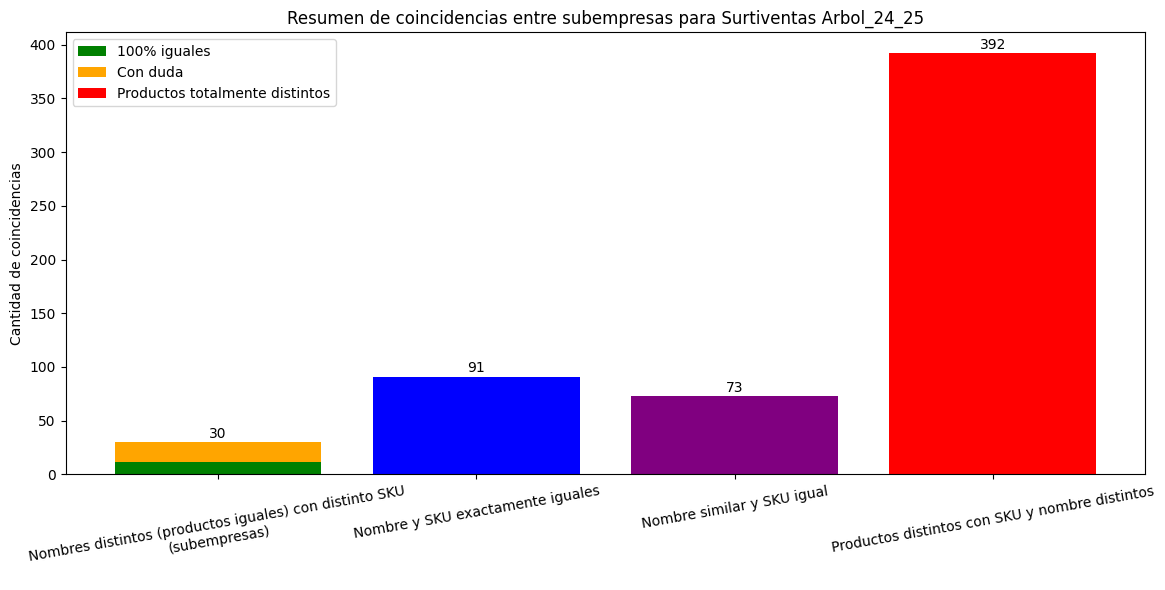

In [37]:
#  special cases devided by 2 because each product appears 2 times - for each subsompany, but normal cases are unique
company = "Surtiventas Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]
visualize(review//2, confident//2, exact//2, partial//2, other, company)



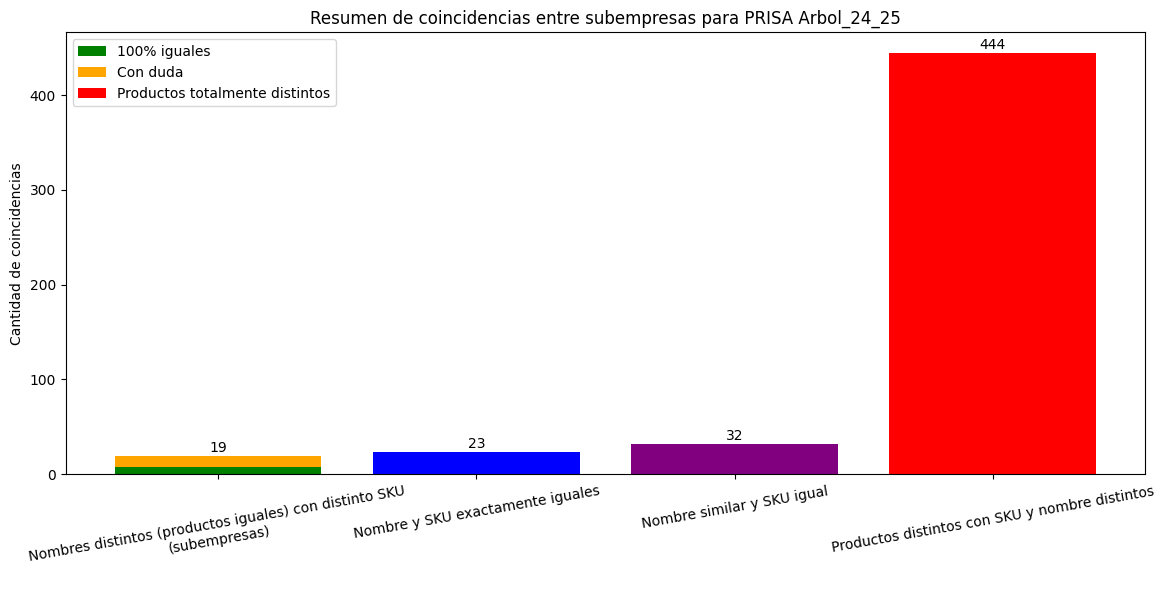

In [38]:
company = "PRISA Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review//2, confident//2, exact//2, partial//2, other, company)

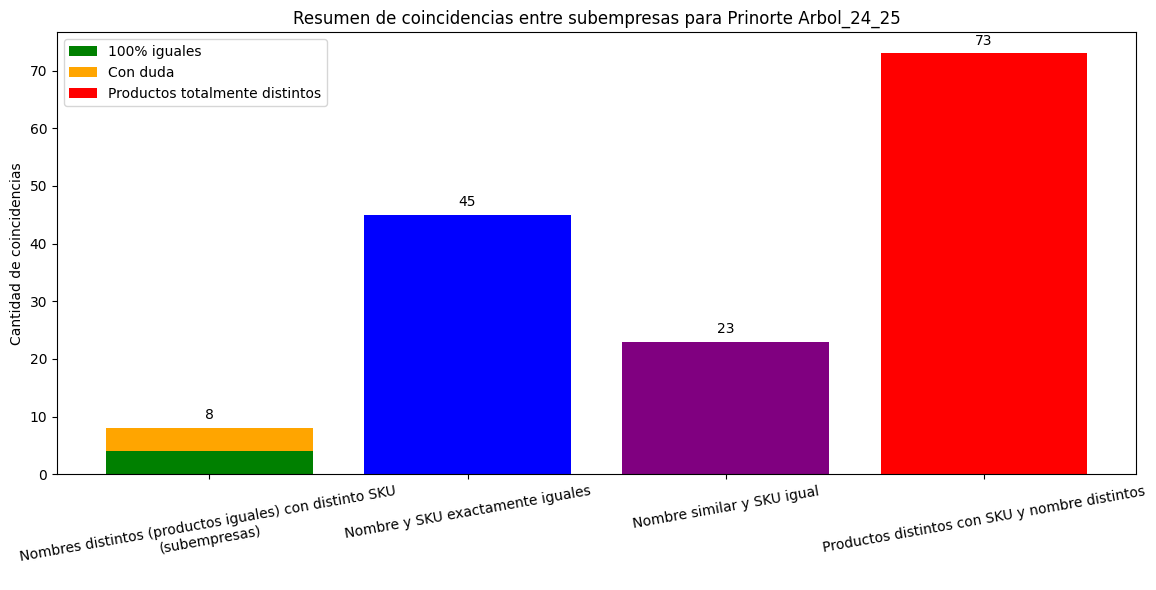

In [39]:
company = "Prinorte Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review//2, confident//2, exact//2, partial//2, other, company)

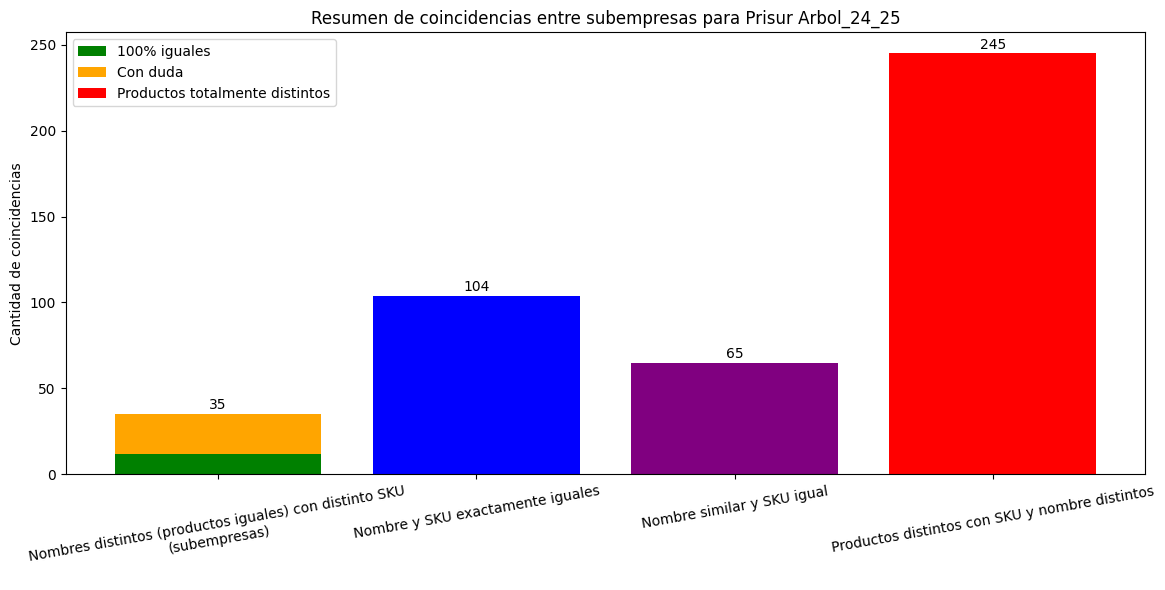

In [40]:
company = "Prisur Arbol_24_25"
review, confident, exact, partial, other = company_shapes[company]

visualize(review//2, confident//2, exact//2, partial//2, other, company)